# Image rectification notebook
This notebook will showcase a method to rectify images such that scale can be obtained for ice objects on the sea plane.

#### Import all libraries we will need

In [82]:
# Importing libraries
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

#### Import image with chessboard pattern and define pixel and world coordinates for corners

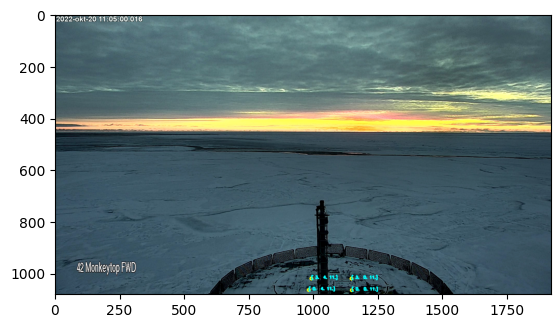

In [171]:
# Read image

im = cv.cvtColor(cv.imread("nabil_img.png"), cv.COLOR_BGR2RGB)
uv_chessboard = np.array([
    (1146, 1065), 
    (980, 1064),
    (990, 1020),
    (1145, 1020)
], dtype='int')

# Define world coordinates of these corners

h = 11# Height of chessboard w.r.t. water plane
w, l = 4, 3 # Width and length of chessboard
X_chessboard = np.array([
    (0, 0, h),
    (0, w, h),
    (l, w, h),
    (l, 0, h)
], dtype='double')


"""
im = cv.cvtColor(cv.imread("rectification.png"), cv.COLOR_BGR2RGB)
uv_chessboard = np.array([
    (500, 570),
    (410, 550),
    (480, 470),
    (570, 480),
], dtype='int')


# Define world coordinates of these corners

h = 5.9 # Height of chessboard w.r.t. water plane
w, l = 1.4, 2.7 # Width and length of chessboard
X_chessboard = np.array([
    (0, 0, h),
    (0, w, h),
    (l, w, h),
    (l, 0, h)
], dtype='double')
"""


im_uv = im.copy()
for i, center in enumerate(uv_chessboard):
    cv.circle(im_uv, tuple(center), radius=5, color=(255, 255, 0), thickness=4)
    cv.putText(im_uv, f"{X_chessboard[i]}", tuple(center), fontFace=0, fontScale=0.5, color=(0, 255, 255), thickness=3)
#im_uv = cv.resize(im_uv[900:, 800:1300], (720, 720))
    
plt.imshow(im_uv)
plt.show()

#### Find camera matrix (This is based on a calibration of only four points. Should have better calibration, but results seem reasonable)

In [172]:
objp = np.array([X_chessboard]).astype(np.float32)
objp[:, :, -1] = 0
imgp = np.array([uv_chessboard]).astype(np.float32)

ret, K, dist, rvecs, tvecs = cv.calibrateCamera(objp, imgp, im.shape[1::-1], None, None)#, flags = cv.CALIB_USE_INTRINSIC_GUESS)

print(K)
print(dist)
print(ret)
print(rvecs)
print(tvecs)

[[1.70223384e+03 0.00000000e+00 9.59499994e+02]
 [0.00000000e+00 3.44939288e+02 5.39499996e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 6.28192629e-10  8.68156359e-10  2.11549164e-10 -1.69845716e-09
   9.84221747e-10]]
0.0
[array([[ 1.26502533],
       [-1.48408715],
       [ 0.63904876]])]
[array([[ 4.18319726],
       [58.16728062],
       [38.18112381]])]


# ----- An algorithm for performing rectification in scale -----
## 1. Retrieve the camera pose
This will be done with the PnP method, associating the image coordinates (uv), with the world-frame coordinates of the corners.

## 2. Use camera pose to project chessboard onto sea plane
Given the camera pose, we can project the chessboard corners (X_chessboard) onto the sea plane

## 3. Use the projected coordinates and image correspondences to create a rectification matrix that will be used for rectification
With the projected coordinates of the checkerboard corners, as well as the image coordinates, we can create a homogrophy between the image plane and the sea-plane. This will be used to rectify images!


# Notation
Vectors will be written on the form ArBC. This should be interpreted as the vector from B to C given in coordinate frame A. For example, the vector from camera (C) to a point (P), given in the world frame (W) can be written WrCP. 

Rotation matrices will be written as R_ab corresponding to the rotation from frame B to frame A. So for example, I can transform a vector from the world frame to the camera frame as follows CrWP = R_cw @ WrWP.

# 1. Retrieve camera pose

In [173]:
# Solve PnP to find camera pose
ret, rvec, t = cv.solvePnP(X_chessboard.astype("double"), uv_chessboard.astype("double"), K, dist)

if not ret:
    print("PnP failed!!!")

else:
    # Get rotations between camera (c) and world (w) frames
    R_cw = Rotation.from_rotvec(rvec.flatten(), degrees=False).as_matrix()
    R_wc = np.linalg.inv(R_cw)
    
    # Define translation vectors between camera and world origin
    CrCW = t
    WrCW = R_wc @ CrCW
    
print(CrCW)
print(WrCW)

[[ 8.14530208]
 [67.80198629]
 [41.71300361]]
[[ 13.70587714]
 [ 21.97780251]
 [-75.71363873]]


# 2. Use camera pose to project chessboard coordinates to sea-level
Use method proposed by Nabil, where the chessboard corners can be scaled by a factor s = H / (H-h) in order to find it's projected size on the sea plane. H corresponds to the height of the camera, and h is the height of the chessboard (w.r.t. to sea plane).

In [192]:
WrWP = X_chessboard.T

# h is already defined, H is found from camera pose WrCW
H = np.abs(WrCW.flatten()[2])
print("Estimated height is", H)

# Multiply all points by H/(H-h)
s = H/(H-h)
X_projected = WrWP[:2] * s

print(f"Corner points projected to the sea plane is:\n{X_projected}\n")

Estimated height is 75.7136387297342
Corner points projected to the sea plane is:
[[0.         0.         3.50993887 3.50993887]
 [0.         4.6799185  4.6799185  0.        ]]



# 3. Create rectification matrix between the image plane and sea-plane

[[  0.      500.     ]
 [  0.      546.7992 ]
 [ 35.09939 546.7992 ]
 [ 35.09939 500.     ]]


Text(0.5, 1.0, 'Rectified image [cm]')

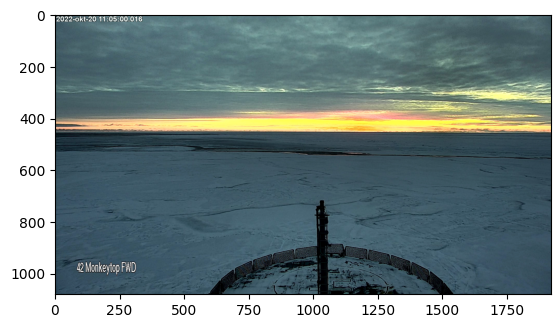

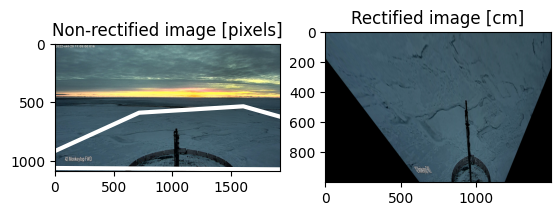

In [193]:
d_x, d_y = 1500, 1000    # Define a distance of interest (How far away from the ship do we want to analyze ice [milimeters]?)
o_x, o_y = 500, 0

# Scale up for higher resolution
X_perspective = X_projected.T
X_perspective = np.float32(X_perspective*10)# To cm
X_perspective[:, 1] += o_x
print(X_perspective)


# Compare image pixels (uv) with projected corner points (X_projected) to find rectification
M = cv.getPerspectiveTransform(uv_chessboard.astype(np.float32), X_perspective)


plt.imshow(im)
im_rectified = cv.warpPerspective(im, M, (d_y, d_x), borderMode = cv.BORDER_CONSTANT)


# Calculated bounds to visualize area observed by rectification
crop_corners = np.array([
    (0, 0, 1),
    (0, d_y, 1),
    (d_x, d_y, 1),
    (d_x, 0, 1)
]).T
uv_corners = np.linalg.inv(M) @ crop_corners
uv_corners /= uv_corners[2]

# Create figure to compare rectification and original image
fig, ax = plt.subplots(1, 2)

ax[0].set_title("Non-rectified image [pixels]")
ax[0].plot(uv_corners[0, np.r_[0:uv_corners.shape[1], 0]], uv_corners[1, np.r_[0:uv_corners.shape[1], 0]], color="white", linewidth=3)
ax[0].imshow(im)

# Just a couple of image flips to visualize better
im_rectified = cv.transpose(im_rectified)
im_rectified = cv.flip(im_rectified, 0)
im_rectified = cv.flip(im_rectified, 1)
ax[1].imshow(im_rectified)
ax[1].set_title("Rectified image [cm]")